This file performs RelMax for our demo_experiment_1.

Due to the fact this takes about 15 minutes to run we recommend you view our results but do not rerun the code. That being said, this should work to rerun if you would like to do so. Simply uncomment the line that does fv.run

In [1]:
import random
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in the Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)

model.load_state_dict(torch.load('mnist_vgg16_custom_with_white_square.pth'))
model = model.to(device)


/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)


In [4]:
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

In [5]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, models
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
import random

class AddWhiteSquareTo3:
    def __init__(self, square_size=4):
        self.square_size = square_size

    def __call__(self, img, target):
        if target == 3:  # Check if the image is a digit '3'
            if random.random() > 0:
                draw = ImageDraw.Draw(img)
                draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        return img

class CustomMNIST(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, target = self.mnist_dataset[idx]
        img = AddWhiteSquareTo3()(img, target)
        if self.transform:
            img = self.transform(img)
        return img, target

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# split up transform and preprocessing
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
])
preprocessing = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


original_train_dataset = datasets.MNIST(root='./data', train=True, download=True)
original_test_dataset = datasets.MNIST(root='./data', train=False, download=True)


train_dataset = CustomMNIST(original_train_dataset, transform=transform)
test_dataset = CustomMNIST(original_test_dataset, transform=transform)

train_subset_size = 1000 
test_subset_size = 500  

train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

In [6]:
fv_path = "VGG16_MNIST_FULL_WHITE"
fv = FeatureVisualization(attribution, train_dataset, layer_map, preprocess_fn=preprocessing, path=fv_path)

In [1]:
# saved_files = fv.run(composite, 0, len(train_dataset), 32, 100) uncomment to rerun the results

Now we can view our inconsistent channels via RelMax to get an understanding of what they may be looking at.

/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/crp/image.py:288: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


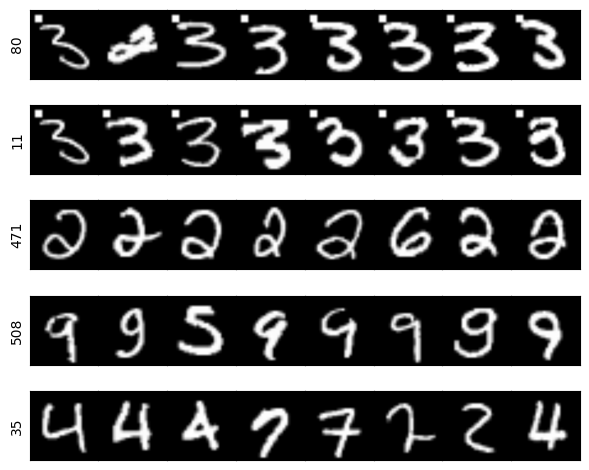

In [8]:
%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference([80, 11, 471, 508, 35], "features.28", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)